# $\S$ 11.7. Example: ZIP Code Data

This example is a character recognition task: Classification of handwritten numerals. This problem captured the attention of the machine learning and neural network community for many years, and has remained a benchmark problem in the field.

FIGURE 11.9 shows some examples of normalized handwritten digits, automatically scanned from envelops by the U.S. Postal Service.

In [1]:
import pandas
import matplotlib.pyplot as plt
import torch

In [2]:
"""FIGURE 11.9. Examples of training cases from ZIP code data.
Each image is a 16x16 8-bit grayscale representation of a handwritten digit."""
# pandas.read_csv is faster than scipy.array(list(csv.reader(...)))
train_df = pandas.read_csv('../data/zipcode/zip.train', delimiter=' ', header=None)
test_df = pandas.read_csv('../data/zipcode/zip.test', delimiter=' ', header=None)
display(f'The Whole Training Dataset {train_df.shape}', train_df.head())

size_train = train_df.shape[0]
size_test = test_df.shape[0]

'The Whole Training Dataset (7291, 258)'

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,257
0,6.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.631,0.862,...,0.823,1.000,0.482,-0.474,-0.991,-1.000,-1.000,-1.000,-1.0,NaN
1,5.0,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,...,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0,NaN
2,4.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-0.109,1.000,-0.179,-1.000,-1.000,-1.000,-1.0,NaN
3,7.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.273,0.684,0.960,0.450,...,1.000,0.536,-0.987,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,NaN
4,3.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.928,-0.204,0.751,0.466,...,0.639,1.000,1.000,0.791,0.439,-0.199,-0.883,-1.000,-1.0,NaN


In [3]:
"""It needs to be split into inputs and outputs,
and also its 257th column should be removed."""
from IPython.display import display

trainy_df = train_df[0].astype(int)
trainx_df = train_df.drop(columns=[0, 257])

testy_df = test_df[0].astype(int)
testx_df = test_df.drop(columns=[0])

display_trainx_df = trainx_df[:16]
display_trainy_df = trainy_df[:16]

display_trainx_mat = display_trainx_df.values
display_trainy_vec = display_trainy_df.values

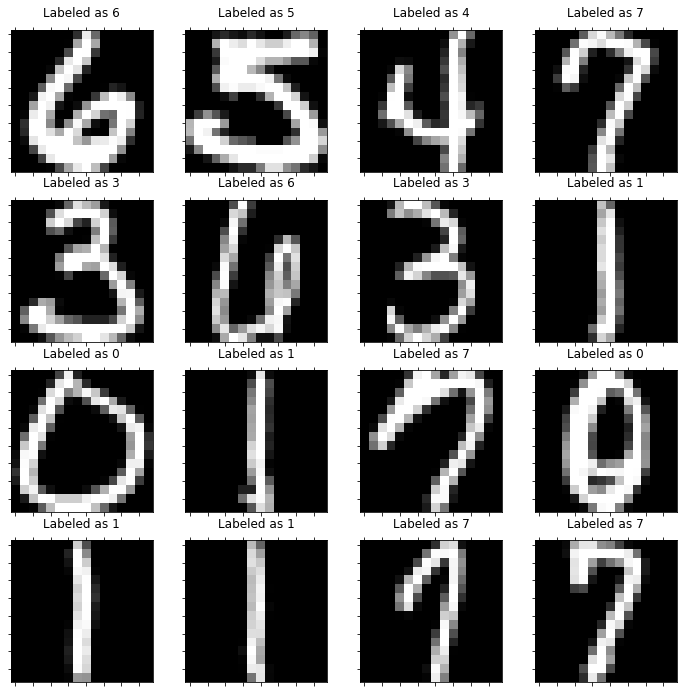

In [4]:
"""I will use matshow since it shows indices of the matrix as it is.
I would like to actually see a few of them.
"""
fig2 = plt.figure(2, figsize=(12, 12))
axes2 = fig2.subplots(4, 4)
for ax2, digit, label in zip(axes2.flatten(), display_trainx_mat, display_trainy_vec):
    ax2.matshow(digit.reshape(16, 16), cmap='gray')
    ax2.tick_params(labeltop=False, labelleft=False)
    ax2.set_title(f'Labeled as {label}')

The original scanned digits are binary and of different sizes and orientations; the images shown here have been deslanted and size normalized, resulting in $16 \times 16$ grayscale images (Le Cun et al., 1990). These 256 pixel values are used as inputs to the neural network classifier.

A _black box_ neural network is not ideally suited to this pattern recognition task, partly because the pixel representation of the images lack certain invariances (such as small rotations of the image). Consequently early attemps with neural networks yielded misclassification rates around 4.5% on various examples of the problem.

In this section we show some of the pioneering efforts to handcraft the neural network to overcome some these deficiencies (Le Cun, 1989), which ultimately led to the state of the art in neural network performance (Le Cun et al., 1998).

### Test environment

#### Data
Although current digit datasets have tens of thousands of training and test examples, the sample size here is deliberately modest in order to emphasize the effects. The examples were obtained by scanning some actual handwritten digits, and then generating additional images by random horizontal shifts (Le Cun, 1989).

There are 320 digits in the training set, and 160 in the test set.

#### Models
Five different networks were fit to the data:
* Net-1: No hidden layer, equivalent to multinomial logistic regression.
* Net-2: One hidden layer, 12 hidden units fully connected.
* Net-3: Two hidden layers locally connected.
* Net-4: Two hidden layers, locally connected with weight sharing.
* Net-5: Two hidden layers, locally connected, two levels of weights sharing.

These are depicted in FIGURE 11.10.

![Architecture of the five networks used in the ZIP code example](./fig11-10.jpg)

Net-1 for example has 256 inputs, one each for the $16 \times 16$ input pixels, and ten output units for each of the digits 0-9. The predicted value $\hat{f}_k(x)$ represents the estimated probability that an image $x$ has digit class $k$, for $k=0,1,2,\cdots,9$.

The networks all have sigmoidal output units, and were all fit with the sum-of-squares error function.

The first network has no hidden layer, and hence is nearly equivalent to a linear multinomial regression model (Exercise 11.4).

Net-2 is a single hidden layer network with 12 hidden units, of the kind described in $\S$ 11.6.

### Details on models

The training set error for all of the networks was 0%, since in all cases there are more parameters than training observations.

The evolution of the test error during the training epochs is shown in FIGURE 11.11. The linear network (Net-1) starts to overfit fairly quickly, while test performance of the others level off at successively superior values.

In [5]:
"""FIGURE 11.11. Test performance curves,
as a function of the number of training epochs, for the five networks."""
n, p, m2, k = size_train, 16*16, 12, 10
learning_rate = 1
epochs = 3000

# Standardize
torchx = torch.from_numpy(trainx_df.values).float()
torchx_mean = torchx.mean(dim=0)
torchx_std = torchx.std(dim=0)
torchx = (torchx - torchx_mean)/torchx_std
varx = torch.autograd.Variable(torchx)
vary = torch.autograd.Variable(torch.from_numpy(trainy_df.values).long(),
                                 requires_grad=False)

torchx_test = torch.from_numpy(testx_df.values).float()
torchx_test = (torchx_test - torchx_mean)/torchx_std
varx_test = torch.autograd.Variable(torchx_test, requires_grad=False)
vary_test = torch.autograd.Variable(torch.from_numpy(testy_df.values).long(),
                                      requires_grad=False)

In [6]:
# Net-1
net1 = torch.nn.Sequential(
    torch.nn.Linear(p, k, bias=True),
)
lossf1 = torch.nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(net1.parameters(), lr=learning_rate,)

In [7]:
errs1_test = []
for epoch in range(epochs):
    y1pred = net1(varx)
    loss1 = lossf1(y1pred, vary)
    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()
    
    # Test for every epoch
    _, test_y1pred = torch.max(net1(varx_test), 1)
    errs1_test.append((vary_test.data == test_y1pred.data).sum()/size_test)

In [9]:
# Net-2
net2 = torch.nn.Sequential(
    torch.nn.Linear(p, m2, bias=True),
    torch.nn.Sigmoid(),
    torch.nn.Linear(m2, k, bias=True),
)
lossf2 = torch.nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(net2.parameters(), lr=learning_rate,)

In [11]:
errs2_test = []
for epoch in range(epochs):
    y2pred = net2(varx)
    loss2 = lossf2(y2pred, vary)
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()
    
    # Test for every epoch
    _, test_y2pred = torch.max(net2(varx_test), 1)
    errs2_test.append((vary_test.data == test_y2pred.data).sum()/size_test)

Training error rate of Net-1: 0.002057330955973158
Training error rate of Net-2: 0.0026059525442325704


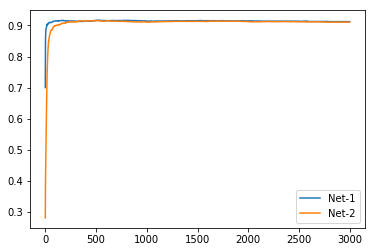

In [14]:
# Check training fit
_, train_y1pred = torch.max(y1pred, 1)
_, train_y2pred = torch.max(y2pred, 1)
print(f'Training error rate of Net-1: {1-sum(train_y1pred.data == vary.data)/n}')
print(f'Training error rate of Net-2: {1-sum(train_y2pred.data == vary.data)/n}')

fig100 = plt.figure(100)
ax100 = fig100.add_subplot(1, 1, 1)
ax100.plot(errs1_test, label='Net-1')
ax100.plot(errs2_test, label='Net-2')
ax100.legend()

The other three networks have additional features which demonstrate the power and flexibility of the neural network paradigm. They introduce constraints on the network, natural for the problem at hand, which allow for more complex connectivity but fewer parameters.

#### Local connectivity
Net-3 uses local connectivity; this means that each hidden unit is connected to only a small patch of units in the layer below.
* In the first hidden layer (an $8 \times 8$ array), each unit takes inputs from a $3 \times 3$ patch of the input layer; for units in the first hidden layer that are two pixels apart, their receptive fields overlap by one row or column, and hence are two pixel apart.
* In the second hidden layer, inputs are from a $5 \times 5$ patch, and again units that are one unit apart have receptive fields that are two units apart.

The weights for all other connections are set to zero.

Local connectivity makes each unit responsible for extracting local features from the layer below, and reduces considerably the total number of weights. With many more hidden units than Net-2, Net-3 has fewer links and hence weights (1226 vs. 3214), and achieves similar performance.

#### Weight sharing
Net-4 and Net-5 have local connectivity with shared weights. All units in a local feature map perform the _same_ operation on different parts of the image, achieved by sharing the same weights.

* The first hidden layer of Net-4 has two $8 \times 8$ array, and each unit takes input from a $3 \times 3$ patch just like in Net-3. However, each of the units in a single $8 \times 8$ feature map share the same set of nine weights (but have their own bias parameter).  

  > This forces the extracted features in different parts of the image to be computed by the same linear functional, and consequently these networks are sometimes known as _convolutional networks_.

* The second hidden layer of Net-4 has no weight sharing, and is the same as in Net-3.

The gradient of the error function $R$ w.r.t. a shared weight is the sum of the gradients of $R$ w.r.t. each connection controlled by the weights in question.

TABLE 11.1 gives the number of links, the number of weights and the optimal test performance for each of the networks.

 | Network Architecture | Links | Weights | % Correct
--- | --- | --- | --- | ---
Net-1 | Single layer network | 2570 | 2570 | 80.0%
Net-2 | Two layer network | 3124 | 3124 | 87.7%
Net-3 | Locally connected | 1226 | 1226 | 88.5%
Net-4 | Constrained network 1 | 2266 | 1132 | 94.0%
Net-5 | Constrained network 2 | 5194 | 1060 | 98.4%

We see that
* Net-4 has more links but fewer weights than Net-3, and superior test performance.
* Net-5 has four $4 \times 4$ feature maps in the second hidden layer, each unit connected to $5 \times 5$ local patch in the layer below.  
  Weights are shared in each of these feature maps.
* Net-5 does the best, having errors of only 1.6%, compared to 13% for the "vanilla" network Net-2.

### Implication of Net-5

The clever design of Net-5, motivated by the fact that features of handwriting style should appear in more than one part of a digit, was the result of many person years of experimentation. This and similar networks gave better performance on ZIP code problem than any other learning methd at that time (early 1990s).

This example also shows that neural networks are not a fully automatic tool, as they are sometimes advertised. As with all statistical models, subject matter knowledge can and should be used to improve their performance.

### Further modern methods

This network was later outperformed by the tangent distance approach (Simard et al., 1993) ($\S$ 13.3.3), which explicitly incorporates natural affine invariances. At this point the digit recognition datasets become test beds for every new learning procedure, and researchers worked hard to drive down the error rates. As of this writing, the best error rates on a large database (60,000 training, 10,000 test observations), derived from standard NIST databases, were reported to be the following (Le Cun et al., 1998):
* 1.1% for tangent distance with a 1NN classifier ($\S$ 13.3.3);
* 0.8% for a degree-9 polynomial SVM ($\S$ 12.3);
* 0.8% for _LeNet-5_, a more complex version of the convolutional network;
* 0.7% for boosted _LeNet-4_. Boosting is described in Chapter 8. _LeNet-4_ is a predecessor of _LeNet-5_.

Le Cun et al. (1998) report a much larger table of performance results, and it is evident that many groups have been working very hard to bring these test error rates down. They report a standard error of 0.1% on the error estimates, which is based on a binomial average with $N=10000$ and $p \approx 0.01$. This implies that error rates within 0.1%-0.2% of one another are statistically equivalent. Realistically the standard error is even higher, since the test data has been implicitly used in the tuning of the various procedures.